## Ultimate Challenge Part 3 -‐ Predictive modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, preprocessing, svm
import seaborn as sns
import json
from pylab import rcParams
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
os.chdir('/home/roman/Documents/Projects/Springboard/17.1 Take Home challenge/ultimate_challenge')

### 1. Exploratory Analysis and Data Cleaning

In [2]:
data_original = json.loads(open('ultimate_data_challenge.json').read())
df = pd.DataFrame(data_original)
print('Dataset features: ' + str(df.columns))
print('\n')
print('First five rows: ')
print(df.head())
print('\n')
print('Dataset info: ')
print(df.info())

Dataset features: Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')


First five rows: 
   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     201

In [3]:
# --------------- Data cleaning --------------- #
# 1. convert dates to datetime objects
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

# convert signup date to number of days since signup:
poll_date = df['last_trip_date'].max()
df['signup_n_days'] = df['signup_date'].apply(lambda x: (poll_date - x).days)

# convert boolean to int:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# 2. replace missing values
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(np.mean(df['avg_rating_by_driver']))
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(np.mean(df['avg_rating_of_driver']))
df['phone'] = df['phone'].fillna('unknown')

# 3. create response variable (driver retention)
df['retention'] = df['last_trip_date'].apply(lambda x: (poll_date - x).days <= 31)
df['retention'] = df['retention'].astype(int)

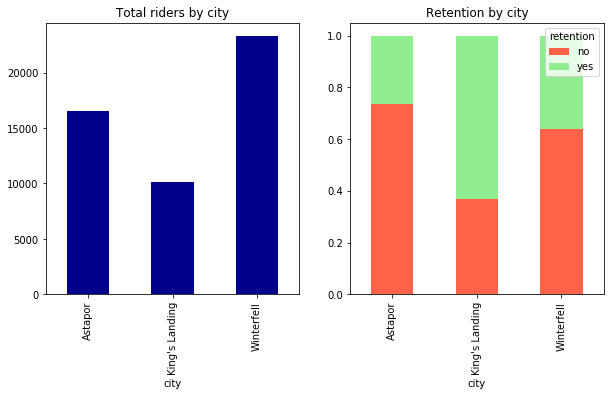

In [4]:
# --------------- data visualization --------------- #
# driver retention by city:
city_ret = df.groupby(by=['city', 'retention']).count().iloc[:, 0]
city_pivot = city_ret.unstack()
city_pivot['total'] = city_pivot[0] + city_pivot[1]
city_pivot['no'] = city_pivot[0] / city_pivot['total']
city_pivot['yes'] = city_pivot[1] / city_pivot['total']
rcParams['figure.figsize'] = 10, 5
fig, axes = plt.subplots(nrows=1, ncols=2)
city_pivot['total'].plot(kind='bar', color='darkblue', title='Total riders by city', ax=axes[0])
plt.subplot(1,2,2)
city_pivot[['no', 'yes']].plot(kind='bar', stacked=True, \
          title = 'Retention by city', color=['tomato','lightgreen'], ax=plt.gca())
plt.show()

The plot above shows that drivers from King's Landing are more likely to be retained (~60%) compared to Astapor (~25%) and Winterfell (~355)

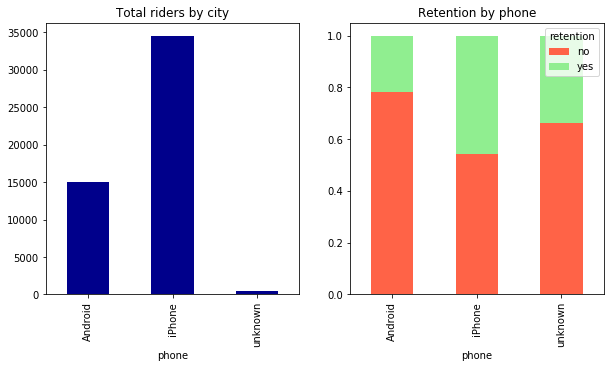

In [5]:
# driver retention by phone:
phone_ret = df.groupby(by=['phone', 'retention']).count().iloc[:, 0]
phone_pivot = phone_ret.unstack()
phone_pivot['total'] = phone_pivot[0] + phone_pivot[1]
phone_pivot['no'] = phone_pivot[0] / phone_pivot['total']
phone_pivot['yes'] = phone_pivot[1] / phone_pivot['total']
fig, axes = plt.subplots(nrows=1, ncols=2)
phone_pivot['total'].plot(kind='bar', color='darkblue', title='Total riders by city', ax=axes[0])
plt.subplot(1,2,2)
phone_pivot[['no', 'yes']].plot(kind='bar', stacked=True, \
          title = 'Retention by phone', color=['tomato','lightgreen'], ax=plt.gca())
plt.show()

Which phone the drivers are using also appears to be correlated to driver retention. IPhone users are more likely to be retained than Android users.

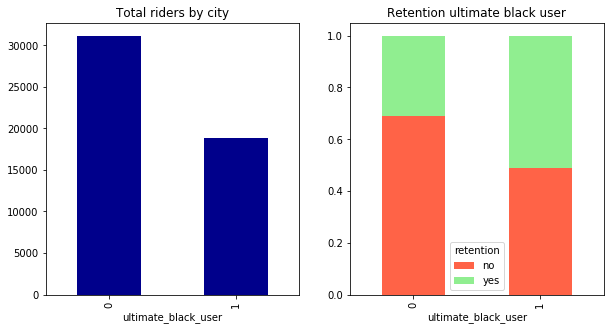

In [6]:
# driver retention by ultimate black user:
ult_ret = df.groupby(by=['ultimate_black_user', 'retention']).count().iloc[:, 0]
ult_pivot = ult_ret.unstack()
ult_pivot['total'] = ult_pivot[0] + ult_pivot[1]
ult_pivot['no'] = ult_pivot[0] / ult_pivot['total']
ult_pivot['yes'] = ult_pivot[1] / ult_pivot['total']
fig, axes = plt.subplots(nrows=1, ncols=2)
ult_pivot['total'].plot(kind='bar', color='darkblue', title='Total riders by city', ax=axes[0])
plt.subplot(1,2,2)
ult_pivot[['no', 'yes']].plot(kind='bar', stacked=True, \
          title = 'Retention ultimate black user', color=['tomato','lightgreen'], ax=plt.gca())
plt.show()

Ultimate black users are more likely to be retained than regular users (~50% vs ~30%)

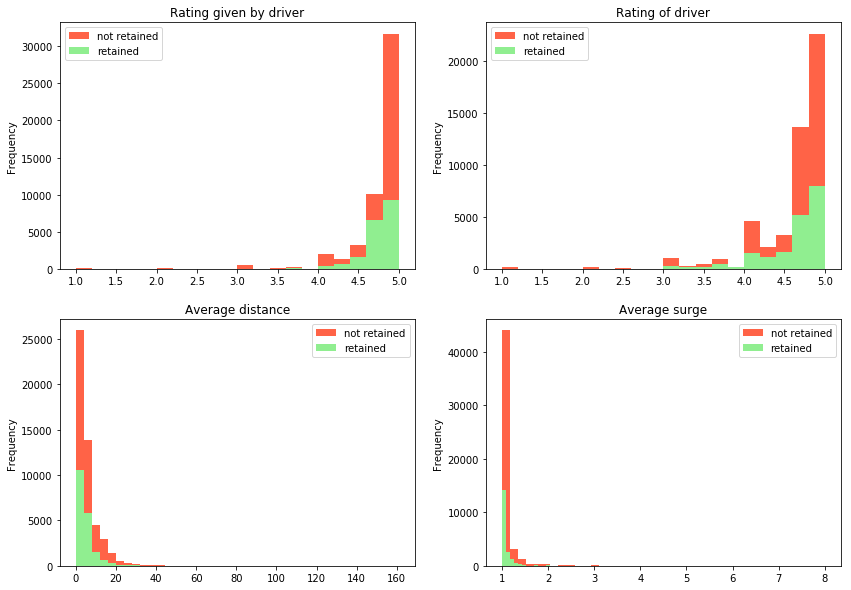

In [7]:
# driver retention by ratings, distance and surge
# avg rating by driver
rcParams['figure.figsize'] = 14, 10
plt.subplot(2,2,1)
df_ret = df[df['retention']==1]
df['avg_rating_by_driver'].plot(kind='hist', bins=20, color='tomato', label=\
      'not retained', legend=True)
df_ret['avg_rating_by_driver'].plot(kind='hist', bins=20, color='lightgreen', 
      label='retained', legend=True)
plt.title('Rating given by driver')
# avg rating of driver:
plt.subplot(2,2,2)
df['avg_rating_of_driver'].plot(kind='hist', bins=20, color='tomato', label=\
      'not retained', legend=True)
df_ret['avg_rating_of_driver'].plot(kind='hist', bins=20, color='lightgreen', 
      label='retained', legend=True)
plt.title('Rating of driver')
# avg distance:
plt.subplot(2,2,3)
df['avg_dist'].plot(kind='hist', bins=40, color='tomato', label=\
      'not retained', legend=True)
df_ret['avg_dist'].plot(kind='hist', bins=40, color='lightgreen', 
      label='retained', legend=True)
plt.title('Average distance')
# avg surge:
plt.subplot(2,2,4)
df['avg_surge'].plot(kind='hist', bins=40, color='tomato', label=\
      'not retained', legend=True)
df_ret['avg_surge'].plot(kind='hist', bins=40, color='lightgreen', 
      label='retained', legend=True)
plt.title('Average surge')
plt.show()

The plots above show the distribition of the ratings given by and of the drivers as well as the average distance driven and the average surge charges. The bars are divided by driver retention to visualize how the correlation between those features and driver retention. The first two plots show that dirvers who give and receive low ratings (3 and below) are less likely to be retained. The third plot shows that a higher average distance is likely positively correlated to driver retention. The same goes for average surge charge.  

### 2. Predictive Model

In [8]:
# --------------- Data preparation --------------- #
# create dummy variables:
dummy_city = pd.get_dummies(df['city'])
dummy_phone = pd.get_dummies(df['phone'])
df_reduced = df[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                'avg_surge', 'signup_n_days', 'surge_pct', 'trips_in_first_30_days', 
                'ultimate_black_user', 'weekday_pct']]
X_data = pd.concat([df_reduced, dummy_city, dummy_phone], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_data, df['retention'], \
        test_size=0.1, random_state=123)

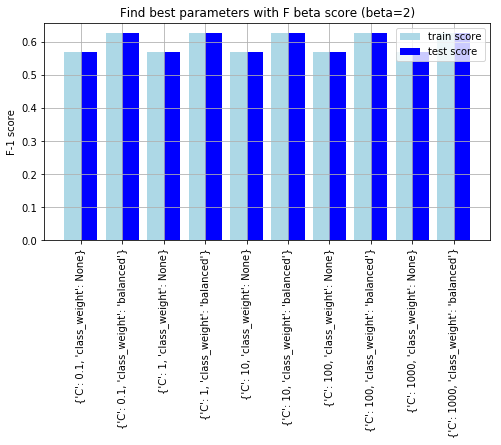

In [9]:
# Logistic Regression: find best parameters with grid search
f1_scorer = metrics.make_scorer(metrics.f1_score)
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [None, 'balanced']}]
clf = GridSearchCV(LogisticRegression(), param_grid, scoring=f1_scorer) 
model = clf.fit(X_train, y_train)
labels = model.cv_results_['params']
tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']
rcParams['figure.figsize'] = 8, 4
plt.bar(x=np.arange(len(tr_score)) - 0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score)) + 0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-1 score')
plt.legend()
plt.grid()
plt.show()

Before evaluating prdicting and evaluating on the logistic regression model we perform grid search to find the best parameters. We use the F1-score as evaluation metric. The results above show that the regularization parameter C does not appear to significantly impact the results. However, class_weight: balanced, which makes sure that we don't predict too many positives/negatives, is preferable.

In [10]:
# Expected prediction performance of random model:
rnd_positives = sum(y_train) / len(y_train)
rnd_TP = rnd_positives**2
rnd_TN = (1 - rnd_positives)**2
rnd_FP = rnd_positives * (1 - rnd_positives)
rnd_FN = (1 - rnd_positives) * rnd_positives
rnd_precision = round(rnd_TP / (rnd_TP + rnd_FP), 3)
rnd_recall = round(rnd_TP / (rnd_TP + rnd_FN), 3)
rnd_f1_score = round(rnd_precision * rnd_recall / (rnd_precision + rnd_recall), 3)
print('Performance random model:')
print('Precision: ' + str(rnd_precision))
print('Recall:    ' + str(rnd_recall))
print('F1-score:  ' + str(rnd_f1_score))
print('\n')

# Predictions with Logistic Regression:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)
train_precision = round(metrics.precision_score(y_train, y_train_pred), 3)
val_precision = round(metrics.precision_score(y_val, y_val_pred), 3)
train_recall = round(metrics.recall_score(y_train, y_train_pred), 3)
val_recall = round(metrics.recall_score(y_val, y_val_pred), 3)
train_f1_score = round(metrics.f1_score(y_train, y_train_pred), 3)
val_f1_score = round(metrics.f1_score(y_val, y_val_pred), 3)
print('Logistic regression results:')
print('Precision training data:   ' + str(train_precision))
print('Recall training data:      ' + str(train_recall))
print('F1-score validation data:  ' + str(train_f1_score))
print('Precision validation data: ' + str(val_precision))
print('Recall validation data:    ' + str(val_recall))
print('F1-score validation data:  ' + str(val_f1_score))

Performance random model:
Precision: 0.384
Recall:    0.384
F1-score:  0.192


Logistic regression results:
Precision training data:   0.596
Recall training data:      0.66
F1-score validation data:  0.626
Precision validation data: 0.603
Recall validation data:    0.664
F1-score validation data:  0.632


We receive an F1 score of 0.632 on the validation set. This is already significantly better than the performance of a random model (that randomly predicts positives with the correct ratio of positives/total samples). Next we want to test if we can do even better using Support Vector Machines. 

In [11]:
# Predictions with Support Vector Machines (linear kernel):
X_data_minmax = preprocessing.MinMaxScaler().fit_transform(X_data)
X_train_minmax, X_val_minmax, _, _ = train_test_split(X_data_minmax, df['retention'], \
        test_size=0.1, random_state=123)
clf = svm.SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train_minmax, y_train)
y_train_pred = clf.predict(X_train_minmax)
y_val_pred = clf.predict(X_val_minmax)
train_precision = round(metrics.precision_score(y_train, y_train_pred), 3)
val_precision = round(metrics.precision_score(y_val, y_val_pred), 3)
train_recall = round(metrics.recall_score(y_train, y_train_pred), 3)
val_recall = round(metrics.recall_score(y_val, y_val_pred), 3)
train_f1_score = round(metrics.f1_score(y_train, y_train_pred), 3)
val_f1_score = round(metrics.f1_score(y_val, y_val_pred), 3)
print('Logistic regression results:')
print('Precision training data:   ' + str(train_precision))
print('Recall training data:      ' + str(train_recall))
print('F1-score validation data:  ' + str(train_f1_score))
print('Precision validation data: ' + str(val_precision))
print('Recall validation data:    ' + str(val_recall))
print('F1-score validation data:  ' + str(val_f1_score))

Logistic regression results:
Precision training data:   0.601
Recall training data:      0.645
F1-score validation data:  0.622
Precision validation data: 0.607
Recall validation data:    0.659
F1-score validation data:  0.632


The performance of SVM with linear kernel is very similar to the one of Logistic Regression. This makes Logistic Regression preferable because the model trains much faster. However, let's see how SVMs with a nonlinear kernel (rbf: radial basis function) perform

In [12]:
# Predictions with Support Vector Machines (RBF kernel):
clf = svm.SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train_minmax, y_train)
y_train_pred = clf.predict(X_train_minmax)
y_val_pred = clf.predict(X_val_minmax)
train_precision = round(metrics.precision_score(y_train, y_train_pred), 3)
val_precision = round(metrics.precision_score(y_val, y_val_pred), 3)
train_recall = round(metrics.recall_score(y_train, y_train_pred), 3)
val_recall = round(metrics.recall_score(y_val, y_val_pred), 3)
train_f1_score = round(metrics.f1_score(y_train, y_train_pred), 3)
val_f1_score = round(metrics.f1_score(y_val, y_val_pred), 3)
print('Logistic regression results:')
print('Precision training data:   ' + str(train_precision))
print('Recall training data:      ' + str(train_recall))
print('F1-score validation data:  ' + str(train_f1_score))
print('Precision validation data: ' + str(val_precision))
print('Recall validation data:    ' + str(val_recall))
print('F1-score validation data:  ' + str(val_f1_score))

Logistic regression results:
Precision training data:   0.635
Recall training data:      0.73
F1-score validation data:  0.679
Precision validation data: 0.643
Recall validation data:    0.746
F1-score validation data:  0.691


SVMs with a radial basis fundtion perform better with an F-1 score of 0.69 (vs 0.63 of the previous models) on the valdation set. 

### 3. Conclusions
This analysis shows that the data collected by Ultimate contains information that is valuable in predicting driver retention. Support Vector Machines with a Radial Basis Function performed best on this prediction problem and might be used by Ultimate to get an idea of which drivers they will likely be able to retain. Since drivers that quit their engagament after a short period are far less profitable, Driver retention is a key factor for Ultimate's business. Ultimate might leverage this analyisis to target their advertisement specifically to drivers that they will be more likely to retain. 